<a href="https://colab.research.google.com/github/BhavaniAM/NLP---Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition_Natural_Language_Processing_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Emotion Recognition

## Setup and Imports

In [ ]:
# Dataset:- https://github.com/dair-ai/**emotion_dataset**
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
     |████████████████████████████████| 212 kB 54.3 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences    
from sklearn.metrics import confusion_matrix, accuracy_score

print('TensorFlow version', tf.__version__)

TensorFlow version 2.8.2


## Importing Data and Data Preparation

In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset
# dataset split:- train:test:validation = 0.8 : 0.1 : 0.1

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [ ]:
tweets, labels = get_tweets(train)

In [ ]:
x = random.randint(0, train.shape[0] - 1)
tweets[x], labels[x]

('i can still feel my legs and they get so cold', 'anger')

## Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)
print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Padding and Truncating Sequences

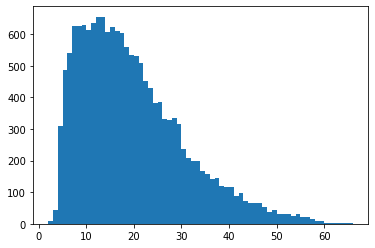

In [ ]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [ ]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [ ]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [ ]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels


In [ ]:
classes = set(labels)
print(classes)

{'love', 'joy', 'surprise', 'sadness', 'fear', 'anger'}


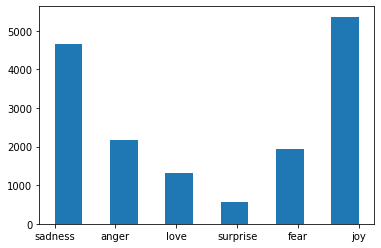

In [ ]:
plt.hist(labels, bins=11)
plt.show()

In [ ]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [ ]:
classes_to_index

{'anger': 5, 'fear': 4, 'joy': 1, 'love': 0, 'sadness': 3, 'surprise': 2}

In [ ]:
index_to_classes

{0: 'love', 1: 'joy', 2: 'surprise', 3: 'sadness', 4: 'fear', 5: 'anger'}

In [ ]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model


In [ ]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [ ]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20
    #,callbacks=[
     #   tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    #]
)

Epoch 1/20
500/500 [==============================] - 18s 16ms/step - loss: 1.3236 - accuracy: 0.4827 - val_loss: 0.8407 - val_accuracy: 0.7090
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.5327 - accuracy: 0.8174 - val_loss: 0.5478 - val_accuracy: 0.8280
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2957 - accuracy: 0.9007 - val_loss: 0.4360 - val_accuracy: 0.8545
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2134 - accuracy: 0.9311 - val_loss: 0.4110 - val_accuracy: 0.8615
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1618 - accuracy: 0.9474 - val_loss: 0.4658 - val_accuracy: 0.8600
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1360 - accuracy: 0.9542 - val_loss: 0.4484 - val_accuracy: 0.8710
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1105 - accuracy: 0.9647 - val_loss: 0.4182 - val_accuracy: 0.876

## Evaluating the Model

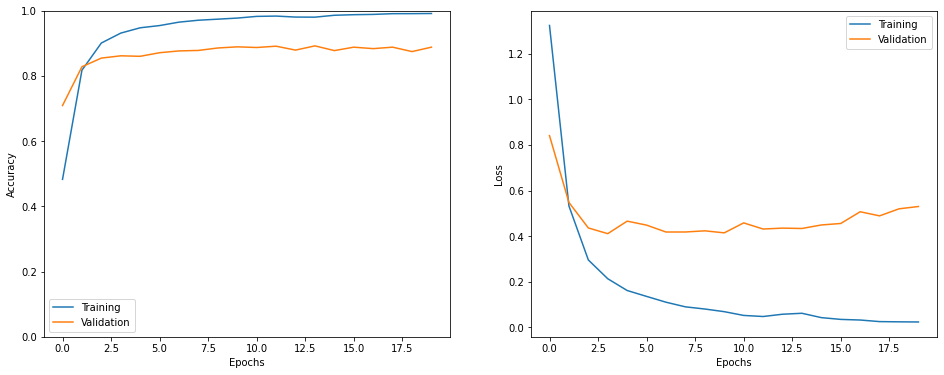

In [ ]:
epochs_trained = len(h.history['loss'])
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
plt.ylim([0., 1.])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.5478 - accuracy: 0.8750


In [ ]:
print(index_to_classes[0])

love


In [ ]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

predict_x = model.predict(test_sequences) 
classes_x = np.argmax(predict_x,axis=1)

Sentence: i feel like i cant have dirty dishes piled up laundry strewn about or toys scattered everywhere
Emotion: sadness


In [ ]:
print(test_labels)

[3 3 3 ... 1 1 4]


In [ ]:
print(classes_x)

[3 3 3 ... 1 1 2]


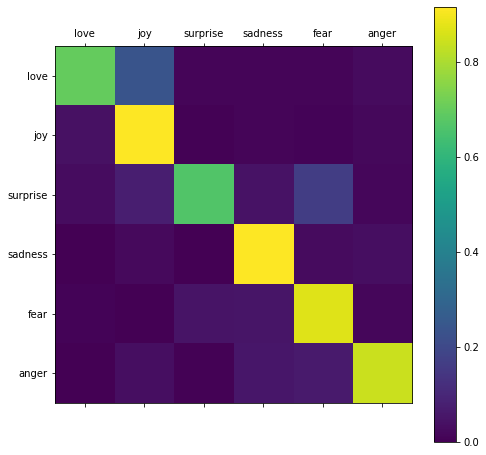

In [ ]:
classes = list(classes)
conf_mat = confusion_matrix(test_labels, classes_x, normalize='true')

plt.figure(figsize=(8, 8))
sp = plt.subplot(1, 1, 1)
ctx = sp.matshow(conf_mat)
plt.xticks(list(range(0, 6)), labels=classes)
plt.yticks(list(range(0, 6)), labels=classes)
plt.colorbar(ctx)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, classes_x)*100)

87.5
